# Result analysis of national SIRDS simulations

In [19]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mticker
import util
from PIL import Image

from sirds_model import epidemic_parameter_defuzzification
from sirds_model_visualization import get_sirds, get_sirds_extras, show_performance, plot_result, plot_parameters, \
    plot_fuzzy_variables, calculate_performance

## Reading data

In [20]:
df_covid_brazil = pd.read_csv('data/output/df_ts_epidemic_episodes.csv')
df_covid_brazil.DATA = pd.to_datetime(df_covid_brazil.DATA, infer_datetime_format=True)
df_covid_brazil['TAXA_CASOS_NOVOS_MEDIA_MOVEL_7_DIAS_PAINEL'] = df_covid_brazil.CASOS_NOVOS_MEDIA_MOVEL_7_DIAS_PAINEL / df_covid_brazil.POPULACAO_2022 * 100000

In [21]:
df_covid_other_countries = pd.read_csv('data/output/df_ts_epidemic_episodes_other_countries.csv')
df_covid_other_countries.date = pd.to_datetime(df_covid_other_countries.date)

In [22]:
df_fitting_recovery_period_brazil = pd.read_csv('data/output/fitting_recovery_period_results.csv')

In [23]:
df_fitting_other_countries = pd.read_csv('data/output/execution_other_countries_results.csv')

In [24]:
df_fitting_other_countries.location.unique()

array(['United States', 'Spain', 'United Kingdom'], dtype=object)

## Show results

### Figure 6

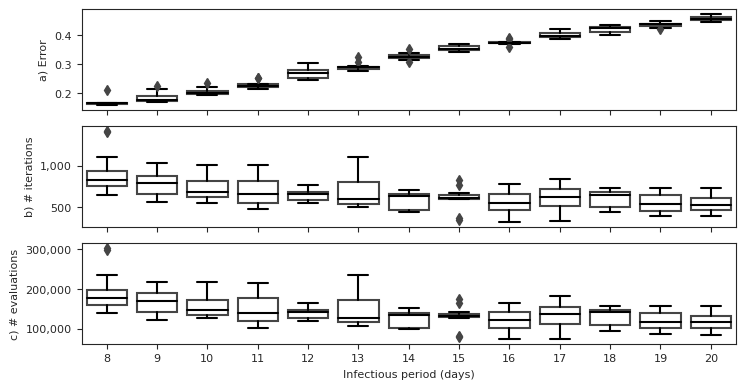

In [25]:
sns.set_style("ticks")
sns.set_palette("gray")
plt.rc('font', size=8)

fig, ax = plt.subplots(3, 1, figsize=(util.centimeter_to_inch(19.05), util.centimeter_to_inch(10)), sharex=True)

sns.boxplot(x=df_fitting_recovery_period_brazil.days_to_recovery.astype(int), y=df_fitting_recovery_period_brazil.result_fun, boxprops=dict(facecolor='white'), ax=ax[0])
ax[0].set_ylabel('a) Error')      
ax[0].set_xlabel(None)
plt.setp(ax[0].artists, edgecolor = 'black')
plt.setp(ax[0].lines, color='black')

sns.boxplot(x=df_fitting_recovery_period_brazil.days_to_recovery.astype(int), y=df_fitting_recovery_period_brazil.result_nit, boxprops=dict(facecolor='white'), ax=ax[1])
ax[1].set_ylabel('b) # iterations')      
ax[1].set_xlabel(None)
plt.setp(ax[1].artists, edgecolor = 'black')
plt.setp(ax[1].lines, color='black')
ax[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))

sns.boxplot(x=df_fitting_recovery_period_brazil.days_to_recovery.astype(int), y=df_fitting_recovery_period_brazil.result_nfev, boxprops=dict(facecolor='white'), ax=ax[2])
ax[2].set_ylabel('c) # evaluations')      
ax[2].set_xlabel(None)
plt.setp(ax[2].artists, edgecolor = 'black')
plt.setp(ax[2].lines, color='black')
ax[2].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax[2].set_xlabel('Infectious period (days)')

plt.tight_layout()

plt.savefig('images/boxplot_sirds_optimization.pdf', bbox_inches="tight")
plt.savefig('images/boxplot_sirds_optimization.tiff', format='tiff', dpi=300, transparent=False, bbox_inches='tight')
img = Image.open("images/boxplot_sirds_optimization.tiff")
img.save("images/boxplot_sirds_optimization_compressed.tiff", compression="tiff_lzw")
plt.show()

### Figure 7

### Brazil

mae_fit :  0.16773103328657954 ( 0.16248176986537077 , 0.17650439865851866 )
sse_D_fit :  0.004042601031263582 ( 0.003762045166403324 , 0.004295086625829507 )
r2_D_fit :  0.9663944821775873 ( 0.9636986383271506 , 0.9689920206478724 )
sse_Rt_fit :  0.009629703881370723 ( 0.007829294542965675 , 0.012908884537209037 )
r2_Rt_fit :  0.8637364701159648 ( 0.8169144050417813 , 0.8890681294319762 )


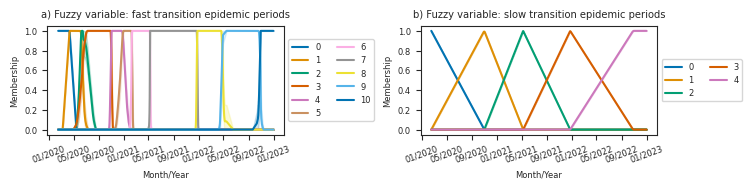

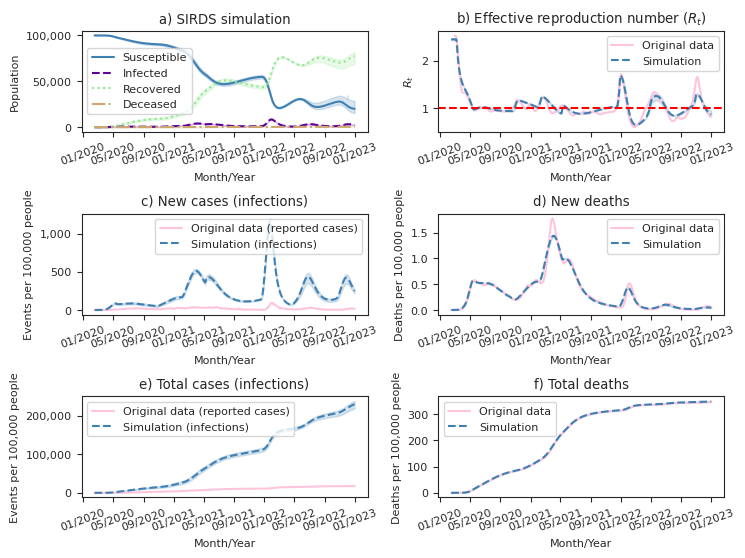

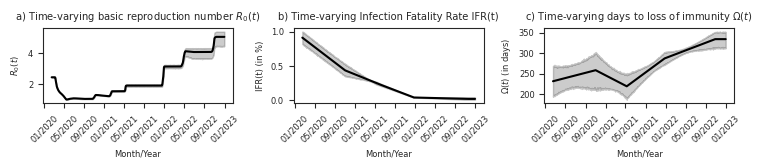

In [17]:
days_to_recovery = 8

df_results = df_fitting_recovery_period_brazil[df_fitting_recovery_period_brazil.days_to_recovery == days_to_recovery]
date_first_case = pd.to_datetime(df_results.date_first_case.unique()[0])
df_covid_brazil = df_covid_brazil[df_covid_brazil.DATA >= date_first_case]

real_reproduction_number = df_covid_brazil.NUMERO_REPRODUCAO_EFETIVO_SRAG_MEDIA.values
real_new_deaths = df_covid_brazil.TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS_SIM.values
real_total_deaths = df_covid_brazil.TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS_SIM.cumsum().values
real_new_cases = df_covid_brazil.TAXA_CASOS_NOVOS_MEDIA_MOVEL_7_DIAS_PAINEL.values
real_total_cases = df_covid_brazil.TAXA_CASOS_NOVOS_MEDIA_MOVEL_7_DIAS_PAINEL.cumsum().values

df_S = pd.DataFrame()
df_I = pd.DataFrame()
df_R = pd.DataFrame()
df_D = pd.DataFrame()
df_I_accumulated = pd.DataFrame()
df_new_deaths = pd.DataFrame()
df_rt = pd.DataFrame()
df_new_cases = pd.DataFrame()
df_r0 = pd.DataFrame()
df_IFR = pd.DataFrame()
df_Omega = pd.DataFrame()
list_fuzzy_fast_transition = []
list_fuzzy_slow_transition = []

dict_performance = {'mae_fit': [], 'sse_D_fit': [], 'r2_D_fit': [], 'sse_Rt_fit': [], 'r2_Rt_fit': []} 

for index, result in df_results.iterrows():    
    y = get_sirds(result)
    S, I, R, D, I_accumulated = y
    min_length = min(len(real_new_deaths), len(D))
    S = S[:min_length]
    I = I[:min_length]
    R = R[:min_length]
    D = D[:min_length]
    I_accumulated = I_accumulated[:min_length]
    N = S[0] + I[0] + R[0] + D[0]
    
    dates = df_covid_brazil[:min_length].DATA.values
    
    D_new_deaths, reproduction_number_sird, I_new_cases, epidemic_periods_with_fast_transition_fuzzy_variable, epidemic_periods_with_slow_transition_fuzzy_variable, days_between_infections_values, case_fatality_probability_values, loss_immunity_in_days_values, estimated_days_between_infections, estimated_case_fatality_probability, estimated_loss_immunity_in_days = get_sirds_extras(result, S, D, I_accumulated)
    
    df_S_temp = pd.DataFrame({'date': dates, 'S': S})
    df_I_temp = pd.DataFrame({'date': dates, 'I': I})
    df_R_temp = pd.DataFrame({'date': dates, 'R': R})
    df_D_temp = pd.DataFrame({'date': dates, 'D': D})
    df_I_accumulated_temp = pd.DataFrame({'date': dates, 'I_accumulated': I_accumulated})
    df_new_deaths_temp = pd.DataFrame({'date': dates[1:], 'deaths': D_new_deaths})
    df_rt_temp = pd.DataFrame({'date': dates, 'rt': reproduction_number_sird})
    df_new_cases_temp = pd.DataFrame({'date': dates[1:], 'cases': I_new_cases})
    df_r0_temp = pd.DataFrame({'date': dates, 'r0': days_to_recovery/estimated_days_between_infections}) 
    df_IRF_temp = pd.DataFrame({'date': dates, 'ifr': estimated_case_fatality_probability})
    df_Omega_temp = pd.DataFrame({'date': dates, 'Omega': estimated_loss_immunity_in_days})
               
    df_S = pd.concat([df_S, df_S_temp])
    df_I = pd.concat([df_I, df_I_temp])
    df_R = pd.concat([df_R, df_R_temp])
    df_D = pd.concat([df_D, df_D_temp])
    df_I_accumulated = pd.concat([df_I_accumulated, df_I_accumulated_temp])
    df_new_deaths = pd.concat([df_new_deaths, df_new_deaths_temp])
    df_rt = pd.concat([df_rt, df_rt_temp])
    df_new_cases = pd.concat([df_new_cases, df_new_cases_temp])
    df_r0 = pd.concat([df_r0, df_r0_temp])
    df_IFR = pd.concat([df_IFR, df_IRF_temp])
    df_Omega = pd.concat([df_Omega, df_Omega_temp])
    list_fuzzy_fast_transition.append(epidemic_periods_with_fast_transition_fuzzy_variable)
    list_fuzzy_slow_transition.append(epidemic_periods_with_slow_transition_fuzzy_variable)
    
    mae_fit, sse_D_fit, r2_D_fit, sse_Rt_fit, r2_Rt_fit = calculate_performance(real_new_deaths, D_new_deaths, real_reproduction_number,  reproduction_number_sird)
    dict_performance['mae_fit'].append(mae_fit)
    dict_performance['sse_D_fit'].append(sse_D_fit)
    dict_performance['r2_D_fit'].append(r2_D_fit)
    dict_performance['sse_Rt_fit'].append(sse_Rt_fit)
    dict_performance['r2_Rt_fit'].append(r2_Rt_fit)    

show_performance(dict_performance)

plot_fuzzy_variables(dates, list_fuzzy_fast_transition, list_fuzzy_slow_transition, 'brazil')     

plot_result(df_S, df_I, df_R, df_D, df_new_deaths, df_I_accumulated, real_new_deaths[:min_length], real_total_deaths[:min_length], real_reproduction_number[:min_length], df_rt, real_total_cases[:min_length], real_new_cases[:min_length], df_new_cases, df_covid_brazil[:min_length].DATA.values, epidemic_periods_with_fast_transition_fuzzy_variable, epidemic_periods_with_slow_transition_fuzzy_variable, id_in_file='brazil')

plot_parameters(df_r0, df_IFR, df_Omega, 'brazil')

### Other countries

United States
mae_fit :  0.15918120999145455 ( 0.15690375253983407 , 0.1612079684415345 )
sse_D_fit :  0.0014502971195398434 ( 0.0013796025220715452 , 0.0015282801627231042 )
r2_D_fit :  0.9730893286709735 ( 0.9717129498428788 , 0.9744537936131328 )
sse_Rt_fit :  0.010090557890548416 ( 0.00959145191766074 , 0.010645742745729336 )
r2_Rt_fit :  0.8410925356535175 ( 0.8324274228570995 , 0.8489086276491632 )


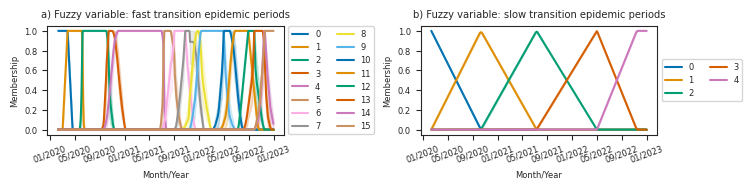

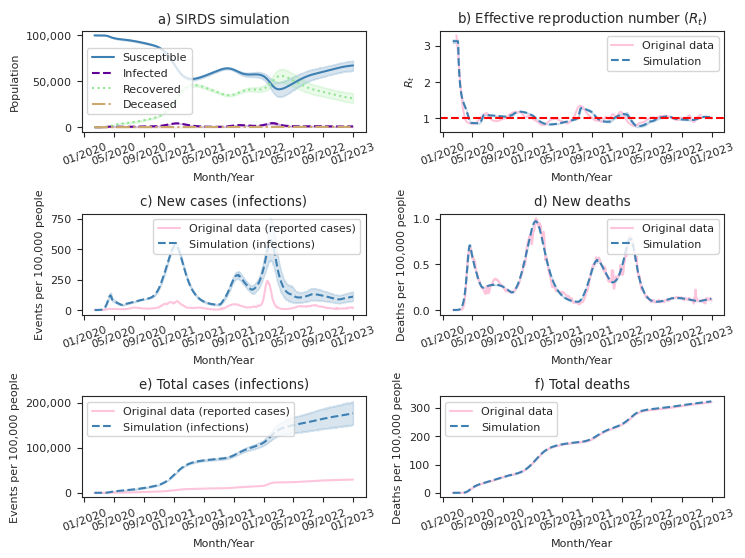

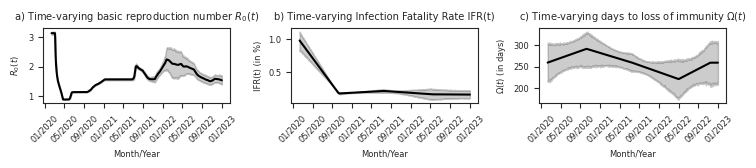

Spain
mae_fit :  0.3231951850662879 ( 0.3172162302827773 , 0.3299794144129185 )
sse_D_fit :  0.006121084473227047 ( 0.005791408584685842 , 0.006490894553425046 )
r2_D_fit :  0.9184888934723465 ( 0.9132300322844268 , 0.9237068732133774 )
sse_Rt_fit :  0.039025556753658645 ( 0.03740304363582767 , 0.040508281857787445 )
r2_Rt_fit :  0.7509086292835774 ( 0.7408902743627911 , 0.7600425028553316 )


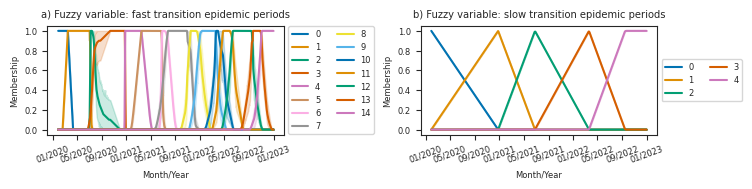

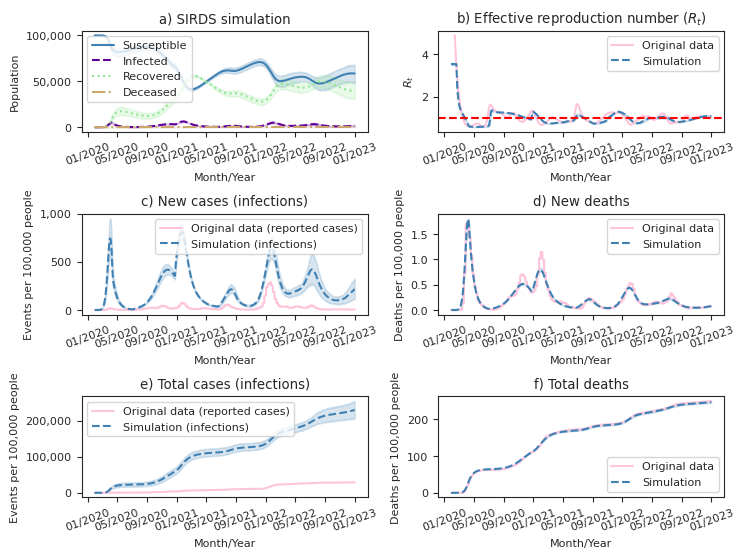

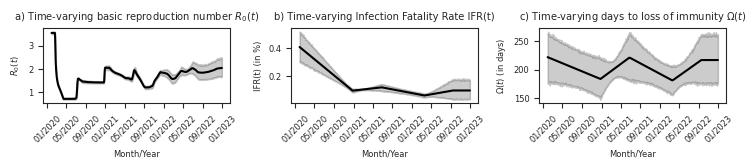

United Kingdom
mae_fit :  0.2236684923243694 ( 0.22026850564794853 , 0.22740126553516854 )
sse_D_fit :  0.002807666817015524 ( 0.002668463426574589 , 0.002926489704419024 )
r2_D_fit :  0.9839642370368964 ( 0.9833118547877328 , 0.984743103514279 )
sse_Rt_fit :  0.02329415836352685 ( 0.022124123631779413 , 0.02444073465542149 )
r2_Rt_fit :  0.8860211920932513 ( 0.8799424596680417 , 0.8918352567354525 )


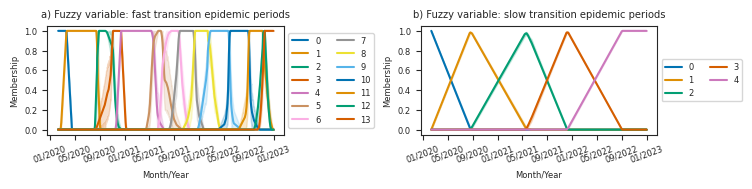

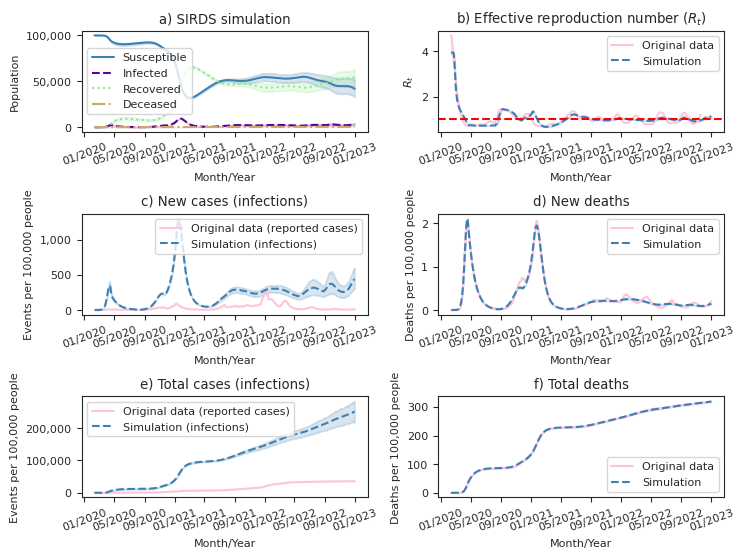

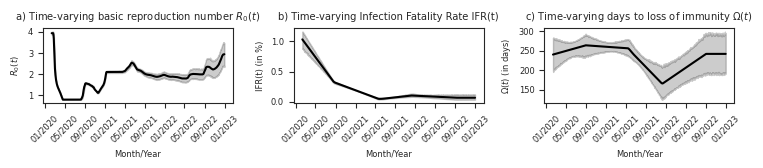

In [18]:
for country in df_fitting_other_countries.location.unique():
    print(country)
    df_results = df_fitting_other_countries[df_fitting_other_countries.location == country]
    date_first_case = pd.to_datetime(df_results.date_first_case.unique()[0])
    
    df_covid_country = df_covid_other_countries[(df_covid_other_countries.location == country) & (df_covid_other_countries.date >= date_first_case)]
    real_reproduction_number = df_covid_country.NUMERO_REPRODUCAO_EFETIVO_ATRASADO_MEDIA.values
    real_new_deaths = df_covid_country.rate_new_deaths_moving_average.values
    real_total_deaths = df_covid_country.rate_new_deaths_moving_average.cumsum().values
    real_new_cases = df_covid_country.rate_new_cases_moving_average.values
    real_total_cases = df_covid_country.rate_new_cases_moving_average.cumsum().values
        
    df_S = pd.DataFrame()
    df_I = pd.DataFrame()
    df_R = pd.DataFrame()
    df_D = pd.DataFrame()
    df_I_accumulated = pd.DataFrame()
    df_new_deaths = pd.DataFrame()
    df_rt = pd.DataFrame()
    df_new_cases = pd.DataFrame()
    df_r0 = pd.DataFrame()
    df_IFR = pd.DataFrame()
    df_Omega = pd.DataFrame()
    list_fuzzy_fast_transition = []
    list_fuzzy_slow_transition = []
    
    dict_performance = {'mae_fit': [], 'sse_D_fit': [], 'r2_D_fit': [], 'sse_Rt_fit': [], 'r2_Rt_fit': []}
    
    for index, result in df_results.iterrows():
        result = result.dropna()
        
        y = get_sirds(result)
        S, I, R, D, I_accumulated = y
        min_length = min(len(real_new_deaths), len(D))
        S = S[:min_length]
        I = I[:min_length]
        R = R[:min_length]
        D = D[:min_length]
        I_accumulated = I_accumulated[:min_length]
        N = S[0] + I[0] + R[0] + D[0]
        
        dates = df_covid_country[:min_length].date.values
        
        D_new_deaths, reproduction_number_sird, I_new_cases, epidemic_periods_with_fast_transition_fuzzy_variable, epidemic_periods_with_slow_transition_fuzzy_variable, days_between_infections_values, case_fatality_probability_values, loss_immunity_in_days_values, estimated_days_between_infections, estimated_case_fatality_probability, estimated_loss_immunity_in_days = get_sirds_extras(result, S, D, I_accumulated)
        
        df_S_temp = pd.DataFrame({'date': dates, 'S': S})
        df_I_temp = pd.DataFrame({'date': dates, 'I': I})
        df_R_temp = pd.DataFrame({'date': dates, 'R': R})
        df_D_temp = pd.DataFrame({'date': dates, 'D': D})
        df_I_accumulated_temp = pd.DataFrame({'date': dates, 'I_accumulated': I_accumulated})
        df_new_deaths_temp = pd.DataFrame({'date': dates[1:], 'deaths': D_new_deaths})
        df_rt_temp = pd.DataFrame({'date': dates, 'rt': reproduction_number_sird})
        df_new_cases_temp = pd.DataFrame({'date': dates[1:], 'cases': I_new_cases})
        df_r0_temp = pd.DataFrame({'date': dates, 'r0': days_to_recovery/estimated_days_between_infections}) 
        df_IRF_temp = pd.DataFrame({'date': dates, 'ifr': estimated_case_fatality_probability})
        df_Omega_temp = pd.DataFrame({'date': dates, 'Omega': estimated_loss_immunity_in_days})
                   
        df_S = pd.concat([df_S, df_S_temp])
        df_I = pd.concat([df_I, df_I_temp])
        df_R = pd.concat([df_R, df_R_temp])
        df_D = pd.concat([df_D, df_D_temp])
        df_I_accumulated = pd.concat([df_I_accumulated, df_I_accumulated_temp])
        df_new_deaths = pd.concat([df_new_deaths, df_new_deaths_temp])
        df_rt = pd.concat([df_rt, df_rt_temp])
        df_new_cases = pd.concat([df_new_cases, df_new_cases_temp])
        df_r0 = pd.concat([df_r0, df_r0_temp])
        df_IFR = pd.concat([df_IFR, df_IRF_temp])
        df_Omega = pd.concat([df_Omega, df_Omega_temp])
        list_fuzzy_fast_transition.append(epidemic_periods_with_fast_transition_fuzzy_variable)
        list_fuzzy_slow_transition.append(epidemic_periods_with_slow_transition_fuzzy_variable)
        
        mae_fit, sse_D_fit, r2_D_fit, sse_Rt_fit, r2_Rt_fit = calculate_performance(real_new_deaths, D_new_deaths, real_reproduction_number,  reproduction_number_sird)
        dict_performance['mae_fit'].append(mae_fit)
        dict_performance['sse_D_fit'].append(sse_D_fit)
        dict_performance['r2_D_fit'].append(r2_D_fit)
        dict_performance['sse_Rt_fit'].append(sse_Rt_fit)
        dict_performance['r2_Rt_fit'].append(r2_Rt_fit)  
        
    show_performance(dict_performance)
    
    plot_fuzzy_variables(dates, list_fuzzy_fast_transition, list_fuzzy_slow_transition, country)

    plot_result(df_S, df_I, df_R, df_D, df_new_deaths, df_I_accumulated, real_new_deaths[:min_length], real_total_deaths[:min_length], real_reproduction_number[:min_length], df_rt, real_total_cases[:min_length], real_new_cases[:min_length], df_new_cases, df_covid_country[:min_length].date.values, epidemic_periods_with_fast_transition_fuzzy_variable, epidemic_periods_with_slow_transition_fuzzy_variable, id_in_file=country)

    plot_parameters(df_r0, df_IFR, df_Omega, country)